Python code adapted from Clerc-Schwarzenbach, F. (2024). A few camels or a whole caravan?. Zenodo. https://doi.org/10.5281/zenodo.10784701

In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from math import pi, sin, cos, tan, acos
from scipy.interpolate import interp1d

In [20]:
# Define paths
caravan_path = r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan' # fill in path to raw data from Caravan
save_path = r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\timeseries\csv\testde'  # fill in path to catchment folders

# Read topology data for latitude
topology = pd.read_csv(r"U:\02_Software\Github\Hy2DL_Caravan\data\caravan\attributes\testde\attributes_other_testde.csv")

# Define the period to be covered
date_start = pd.to_datetime("1980-01-01")
date_end = pd.to_datetime("2020-12-31")

# Define subsets of interest
subsets = ["testde"]

In [21]:
topology

,gauge_id,gauge_lat,gauge_lon,gauge_name,country,area
0,testde_1,49.136540,8.74234,Menzingen Weiherbach,Germany,3.443766
1,testde_2,49.314977,8.84000,Eschelbronn Schwarzbach,Germany,196.492301
2,testde_3,49.314977,8.84000,Eschelbronn Schwarzbach,Germany,196.492301


In [24]:
# Function to calculate Hargreaves-based evapotranspiration
# Function to calculate Hargreaves-based evapotranspiration
def hargreaves_adapted(t_mean, t_diff, p, lat, jday):
    # Adapted Hargreaves equation as per Adam et al. (2006)
    phi = (lat * np.pi) / 180
    delta = 0.4093 * np.sin((2 * np.pi / 365) * jday - 1.405)
    dr = 1 + 0.033 * np.cos((2 * np.pi / 365) * jday)
    omega_s = np.arccos(-np.tan(phi) * np.tan(delta))

    # Adjust omega_s for polar regions
    omega_s[np.tan(phi) * np.tan(delta) < -1] = 0
    omega_s[np.tan(phi) * np.tan(delta) > 1] = np.pi

    S0 = 15.392 * dr * (omega_s * np.sin(phi) * np.sin(delta) + np.cos(phi) * np.cos(delta) * np.sin(omega_s))
    pet = 0.0013 * S0 * (t_mean + 17.0) * (t_diff - 0.0123 * p) ** 0.76

    # Set negative PET values to 0
    pet = np.maximum(pet, 0)

    # Linear interpolation for NA values
    valid_idx = np.isfinite(pet)
    if np.any(~valid_idx):
        f_interp = interp1d(np.flatnonzero(valid_idx), pet[valid_idx], bounds_error=False, fill_value=0)
        pet[~valid_idx] = f_interp(np.flatnonzero(~valid_idx))

    return pet

In [16]:
catchments = [os.path.join(save_path, f) for f in os.listdir(save_path) if os.path.isdir(os.path.join(save_path, f)) and subsets in f]

TypeError: 'in <string>' requires string as left operand, not list

In [25]:
# Get gauge latitude of the catchment
lat = 49.314977

# Read timeseries data for the catchment
timeseries = pd.read_csv(r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\timeseries\csv\testde\testde_3.csv')

# Filter data within the date range
timeseries['date'] = pd.to_datetime(timeseries['date'])
timeseries = timeseries[(timeseries['date'] >= date_start) & (timeseries['date'] <= date_end)]

# Rename columns
timeseries = timeseries[['date', 'temperature_2m_mean', 'temperature_2m_min', 'temperature_2m_max', 'total_precipitation_sum']]
timeseries.columns = ['date', 'mean_temp', 'min_temp', 'max_temp', 'prec']

# Calculate Julian day
timeseries['jday'] = timeseries['date'].dt.dayofyear

# Calculate monthly values for precipitation and temperature
timeseries['month'] = timeseries['date'].dt.month
timeseries['year'] = timeseries['date'].dt.year

P_data = timeseries.groupby(['month', 'year'])['prec'].sum().reset_index(name='P')
tmin_data = timeseries.groupby(['month', 'year'])['min_temp'].mean().reset_index(name='tmin')
tmax_data = timeseries.groupby(['month', 'year'])['max_temp'].mean().reset_index(name='tmax')

# Merge tmin and tmax
t_data = pd.merge(tmin_data, tmax_data, on=['month', 'year'])
t_data['T_diff'] = t_data['tmax'] - t_data['tmin']

# Add P and T_diff to the timeseries
timeseries = timeseries.merge(P_data, on=['month', 'year'], how='left')
timeseries = timeseries.merge(t_data[['month', 'year', 'T_diff']], on=['month', 'year'], how='left')

# Convert relevant columns to numpy arrays for the function
mean_temp = timeseries['mean_temp'].to_numpy()
T_diff = timeseries['T_diff'].to_numpy()
P = timeseries['P'].to_numpy()
jday = timeseries['jday'].to_numpy()

# Calculate potential evapotranspiration
timeseries['evap'] = hargreaves_adapted(mean_temp, T_diff, P, lat, jday)

# Save the output
timeseries[['evap']].to_csv(r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\attributes\testde\evap_era5.csv', header=False, index=False)

In [30]:
original = pd.read_csv(r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\timeseries\csv\testde\testde_3.csv')
# Filter data within the date range
original['date'] = pd.to_datetime(original['date'])

<Axes: >

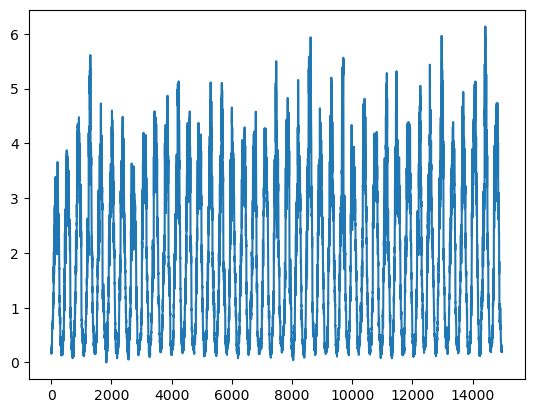

In [28]:
timeseries['evap'].plot()

In [32]:
# Get gauge latitude of the catchment
lat = 49.314977

# Read timeseries data for the catchment
timeseries = pd.read_csv(r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\timeseries\csv\testde\testde_3.csv')

# Filter data within the date range
timeseries['date'] = pd.to_datetime(timeseries['date'])
timeseries = timeseries[(timeseries['date'] >= date_start) & (timeseries['date'] <= date_end)]

# Rename columns
timeseries = timeseries[['date', 'temperature_2m_mean', 'temperature_2m_min', 'temperature_2m_max', 'testde_2']]
timeseries.columns = ['date', 'mean_temp', 'min_temp', 'max_temp', 'prec']

# Calculate Julian day
timeseries['jday'] = timeseries['date'].dt.dayofyear

# Calculate monthly values for precipitation and temperature
timeseries['month'] = timeseries['date'].dt.month
timeseries['year'] = timeseries['date'].dt.year

P_data = timeseries.groupby(['month', 'year'])['prec'].sum().reset_index(name='P')
tmin_data = timeseries.groupby(['month', 'year'])['min_temp'].mean().reset_index(name='tmin')
tmax_data = timeseries.groupby(['month', 'year'])['max_temp'].mean().reset_index(name='tmax')

# Merge tmin and tmax
t_data = pd.merge(tmin_data, tmax_data, on=['month', 'year'])
t_data['T_diff'] = t_data['tmax'] - t_data['tmin']

# Add P and T_diff to the timeseries
timeseries = timeseries.merge(P_data, on=['month', 'year'], how='left')
timeseries = timeseries.merge(t_data[['month', 'year', 'T_diff']], on=['month', 'year'], how='left')

# Convert relevant columns to numpy arrays for the function
mean_temp = timeseries['mean_temp'].to_numpy()
T_diff = timeseries['T_diff'].to_numpy()
P = timeseries['P'].to_numpy()
jday = timeseries['jday'].to_numpy()

# Calculate potential evapotranspiration
timeseries['evap'] = hargreaves_adapted(mean_temp, T_diff, P, lat, jday)

# Save the output
timeseries[['evap']].to_csv(r'U:\02_Software\Github\Hy2DL_Caravan\data\caravan\attributes\testde\evap_lstm.csv', header=False, index=False)